# CNN Lab 2: Segmentation of Human Blood Cells using Convolutional Neural Networks

For this lab, we use the [Human White Blood Cell images](https://github.com/zxaoyou/segmentation_WBC) from [Jiangxi Tecom Science Corporation, China](http://en.tecom-cn.com/).

<img src="illustrations/WhiteBloodCells.png" width="500px" title="Blood cell illustration (Wikipedia)" align="center"/>
<center><i>(Illustration from <a href="https://en.wikipedia.org/wiki/White_blood_cell">Wikipédia</a>)</i></center>

<br/>
The dataset contains three hundred 120x120 RGB images with one blood cell per image, and corresponding segmentation masks. The segmentation mask was manually sketched by domain experts, with the background, cytoplasms and nuclei pixels labelled as 0, 1 and 2 respectively.

<img src="illustrations/WBC_Dataset1.png" title="Blood cells dataset" align="center"/>

These images and masks are in the **data/bloodcells_seg/** folder:
```
└── data
    └── bloodcells_seg
        ├── masks
        │   ├── all
        └── images
            ├── all
```

We want to use convolutional neural networks to do pixel-wise classification of these blood cells images into background / cytoplasm / nuclei.

In [1]:
# First we import useful modules like numpy and Keras layers

import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Input
from tensorflow.keras.layers import Conv2DTranspose, concatenate, UpSampling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# cnn_helper contains some useful functions for this lab
import cnn_helper

import tensorflow as tf
import matplotlib.pyplot as plt

We will load both the images and the masks as generators, and combine both generators into a zip of generators.

In [2]:
IMG_SIZE = 128
NUM_CLASSES = 3 # Background, cytoplasm, nuclei
N_CHANNELS = 3  # R,G,B
BATCH_SIZE = 8

seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255 #We need to rescale png images from integers to floats
)
mask_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Load image and mask generators for training
train_image_generator = image_datagen.flow_from_directory(
    directory='data/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='training',
    color_mode='rgb',
    shuffle=False)

train_mask_generator = mask_datagen.flow_from_directory(
    directory='data/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='training',
    color_mode='grayscale',
    shuffle=False)

train_generator = zip(train_image_generator, train_mask_generator)

# Load image and mask  generators for validation
val_image_generator = image_datagen.flow_from_directory(
    directory='data/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='rgb',
    shuffle=False)

val_mask_generator = mask_datagen.flow_from_directory(
    directory='data/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='grayscale',
    shuffle=False)

val_generator = zip(val_image_generator, val_mask_generator)

Found 240 images belonging to 1 classes.
Found 240 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


We can now check that the generators deliver our data:

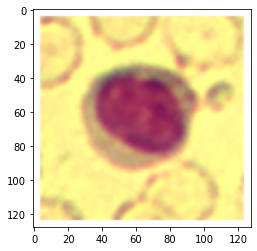

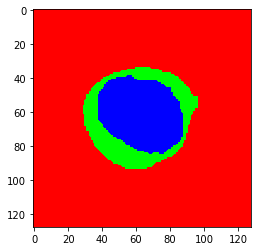

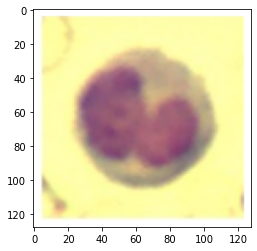

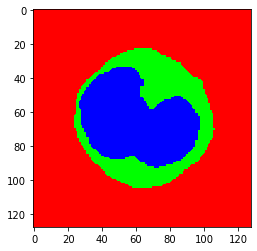

In [3]:
from matplotlib.colors import ListedColormap
cMap = ListedColormap(['red', 'lime', 'blue'])

images,masks = next(train_generator)
for i in range(0,2):
    plt.figure()
    plt.imshow(images[i], cmap=cMap)
    plt.figure()
    plt.imshow(masks[i,:,:,0], cmap=cMap)

# Building a basic UNet Model

<img src="illustrations/unet.png" title="Unet model"/>

This time we will use the Keras functional API to build our model:

In [4]:
inputs = Input((IMG_SIZE, IMG_SIZE, N_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax') (c9)

As our ground truth is represented by integers on a mask (0 for background, 1 for cytoplasm, 2 for nuclei pixels) and not hot-one encoded, we will use the Keras SparseCategoricalCrossentropy loss function (see https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

In [5]:
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

For training, we add a callback function that will plot `num_plot` results from validation after each epoch, to follow in real time the training of our network.

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.7606

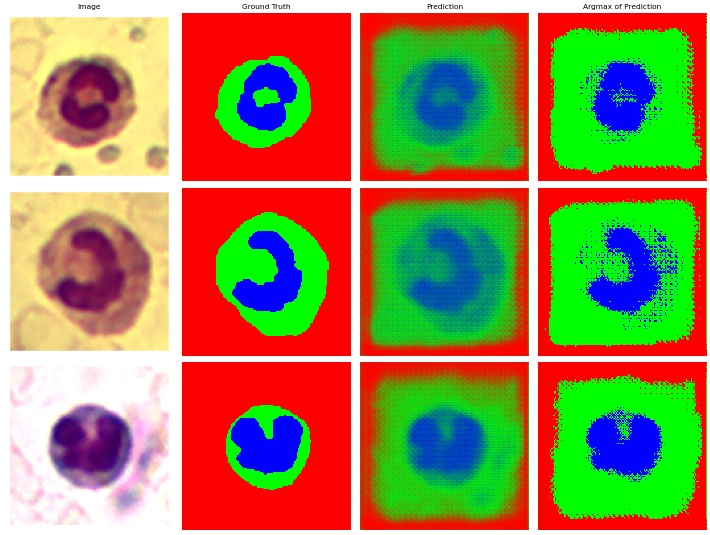

60/60 [==============================] - 53s 878ms/step - loss: 0.4694 - accuracy: 0.7606 - val_loss: 0.7926 - val_accuracy: 0.3880
Epoch 2/20
 5/60 [=>............................] - ETA: 43s - loss: 0.2341 - accuracy: 0.7603

KeyboardInterrupt: 

In [6]:
model.fit(
    train_generator,
    steps_per_epoch=240/BATCH_SIZE, 
    epochs=20,
    validation_data=(val_generator),
    validation_steps=64/BATCH_SIZE, 
    callbacks=[
        cnn_helper.PlottingKerasCallback(
            test_batch=next(val_generator),
            num_plot=3 # how many validation examples to plot at each epoch (maximum = BATCH_SIZE)
        )
    ])

We can now plot some other examples from validation:

In [ ]:
cnn_helper.plot_prediction (model, next(val_generator), BATCH_SIZE)

## Tuning of the model
You can now try to tune your model by changing the learning rate of the Adam optimizer, the dropout, the batch size, or any other parameter you want.

# Other models

To simplify the construction of our networks, we will now use the `segmentation_model` python library (install using `pip install segmentation_model`).

The main features of this library are:
 - High level API (just two lines of code to create model for segmentation)
 - 4 models architectures for binary and multi-class image segmentation (including legendary Unet)
 - 25 available backbones for each architecture
 
You can read more about the `segmentation_model` library at https://github.com/qubvel/segmentation_models.

## List of models:

| Unet | Linknet |
| --- | --- |
| <img width="500px" src="https://raw.githubusercontent.com/qubvel/segmentation_models/master/images/unet.png" title="UNet"/> | <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/linknet.png" title="Linknet"/> |

| PSPNet | FPN |
| --- | --- |
| <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/pspnet.png" title="UNet"/> | <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/fpn.png" title="Linknet"/> |

## List of backbones:

| Type | Names |
| --- | --- |
| VGG | `vgg16` `vgg19` |
| ResNet | `resnet18` `resnet34` `resnet50` `resnet101` `resnet152` |
| SE-ResNet | `seresnet18` `seresnet34` `seresnet50` `seresnet101` `seresnet152` |
| ResNeXt | `resnext50` `resnext101` |
| SE-ResNeXt | `seresnext50` `seresnext101` |
| SENet154 | `senet154` |
| DenseNet | `densenet121` `densenet169` `densenet201` |
| Inception | `inceptionv3` `inceptionresnetv2` |
| MobileNet | `mobilenet` `mobilenetv2` |
| EfficientNet | `efficientnetb0` `efficientnetb1` `efficientnetb2` `efficientnetb3` `efficientnetb4` `efficientnetb5` efficientnetb6` efficientnetb7` |

In [7]:
# This is needed for the segmentation_model library
import os
os.environ["SM_FRAMEWORK"]="tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


You can try different models and backbone from the list above.

In [8]:
# Let's load the Unet model, using the VGG16 backbone
model = sm.Unet(
    'mobilenet',
    #encoder_weights=None,
    encoder_weights='imagenet',
    classes=NUM_CLASSES,
    activation='softmax',
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

#print (model.summary())

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.8520 - accuracy: 0.5321

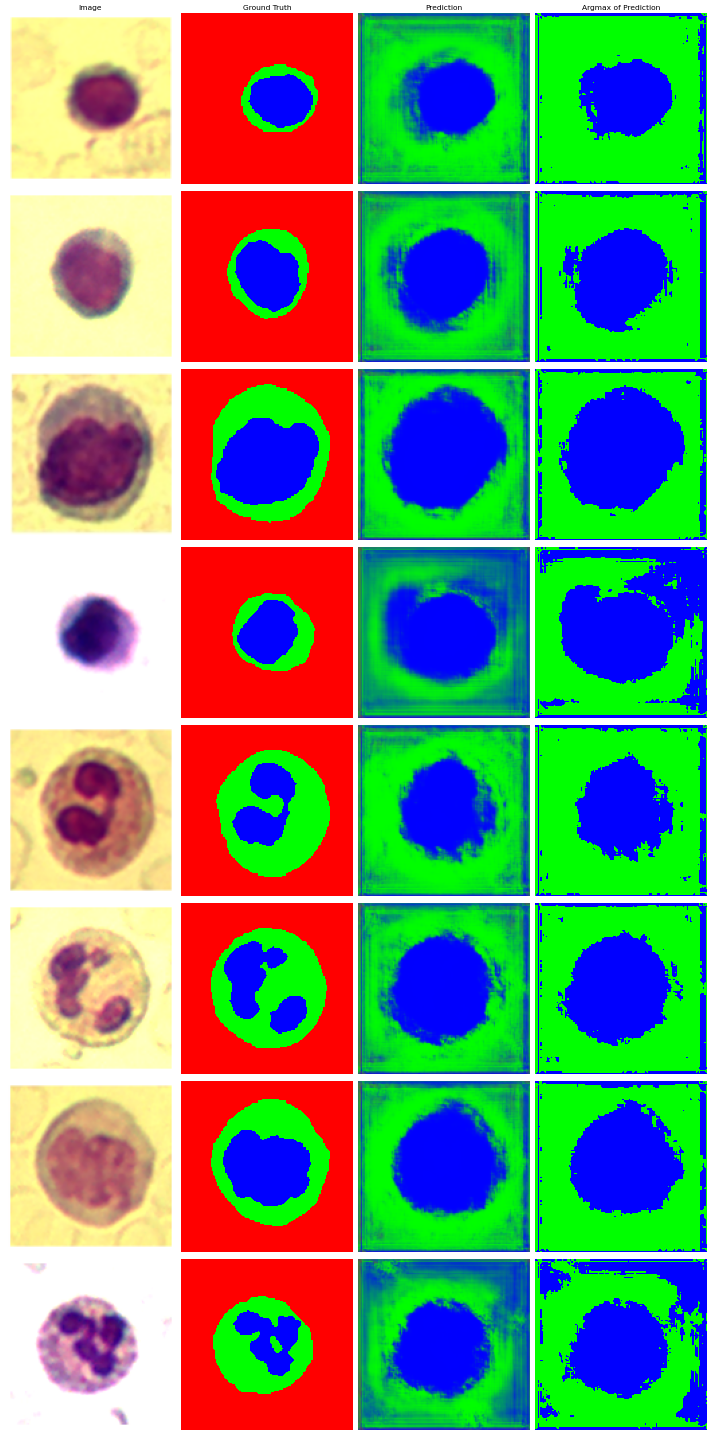

60/60 [==============================] - 91s 2s/step - loss: 0.8520 - accuracy: 0.5321 - val_loss: 7.4912 - val_accuracy: 3.6621e-05
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.7065

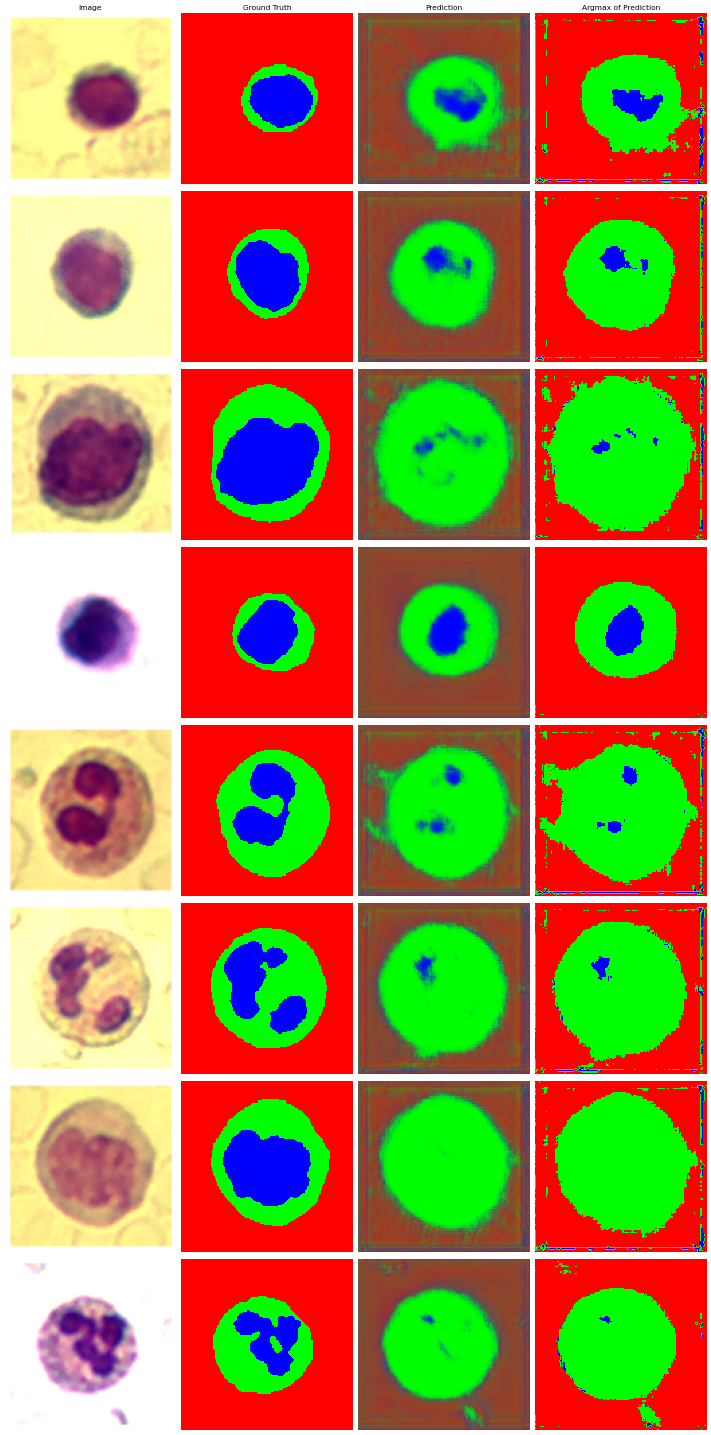

60/60 [==============================] - 92s 2s/step - loss: 0.4667 - accuracy: 0.7065 - val_loss: 1.3962 - val_accuracy: 0.5822
Epoch 3/30
 9/60 [===>..........................] - ETA: 1:14 - loss: 0.3490 - accuracy: 0.7251

KeyboardInterrupt: 

In [9]:
# We can now compile and train with the same parameters as before:

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.fit(
    train_generator,
    steps_per_epoch=240/BATCH_SIZE, 
    epochs=30,
    validation_data=(val_generator),
    validation_steps=64/BATCH_SIZE, 
    verbose=1,
    callbacks=[cnn_helper.PlottingKerasCallback(
        test_batch=next(val_generator),
        num_plot=2 # maximum num_plot is BATCH_SIZE
    )],
)

In [ ]:
cnn_helper.plot_prediction (model, next(val_generator), BATCH_SIZE)